# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of the natural language (could be sequences or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq)

## Check for GPU

In [ ]:
!nvidia-smi -L

## Get the helper functions 

In [ ]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset

The dataset we are going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster)

In [ ]:
# Unzip data
unzip_data("nlp_getting_started.zip")

## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way would be to use python.

Another way to do this is pandas

In [9]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Visualizing a sample
train_df["text"][1]

In [10]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1,random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like?
test_df.head()

In [ ]:
# How many examples of each class?
train_df.target.value_counts()

In [ ]:
# How many total samples
len(train_df), len(test_df)

In [11]:
# Let's visualize some random training examples
import random

random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
So this storm just came out of no where. .fuck me its cool

---

Target: 0 (not real disaster)
Text:
I HATE WHEN IM TRYING TO STRAIGHTEN MY HAIR AND MY BROTHER COMES SWOOPING IN BEHIND ME AND SCARES ME I JUST BURNED MY FINGER

---

Target: 0 (not real disaster)
Text:
am boy @Crash_______  https://t.co/f5Ylp7pfN7

---

Target: 1 (real disaster)
Text:
70 Years After Atomic Bombs Japan Still Struggles With Wartime Past: The anniversary of the devastation wroug... http://t.co/EfsA6pbeMC

---

Target: 0 (not real disaster)
Text:
@DeeDee_Casey been on tour in the day to Hellfire caves! Would love to investigate the place though!

---



### Split data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation
                                                                            random_state=42)


In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

In [ ]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

## Converting text into numbers

In NLP, there are two main concepts for turning text into numbers:

* Tokenization - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:

* Embeddings - An embedding is a representation of natural language which can be learned

### Text vectorization (tokenization)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int",
                                    output_sequence_length=None) # pads sequence to the largest sequence
                                    # pad_to_max_tokens=True)

In [ ]:
# Length of train setences
print(train_sentences[0].split())
len(train_sentences[0].split())

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocab
max_length = 15 # the length of our sequences (i.e. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])      

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our vocab
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

### Creating an Embedding using Embedding Layer

To make our embedding, we're going to use TF embedding layer.

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `ouput_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # input shape
                             output_dim=128, # output shape
                             input_length=max_length) # how long is each input

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original Text:\n {random_sentence} \
        \n\n Embedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

## Modelling a text dataset (running a series of experiments)

Now we have got a way to turn our text sequences into numbers, it is time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM (RNN)
* Model 3: GRU (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D CNN
* Model 6: TF Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as Model 6 with 10% of training data

How are we going to approach all of these?
1. Create a model
2. Build a model
3. Fit a model
4. Evaluate a model

### Model 0: Getting a baseline

> It is common practice to use non-DL algorithms as a baseline because of their speed. Later, we can employ deep learning and see how it improves the result

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()), # convert words to numbers
    ("clf",MultinomialNB()), # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences,val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [26]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predicitons with difference metrics ever time, however, this can be fixed with a function

Let's create a function to compare our model's predictions to its truth labels using:
* Accuracy
* Precision
* Recall
* F1-Score

In [ ]:
# Function to evaluate metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true,y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """

    # Calculate accuracy
    model_accuracy = accuracy_score(y_true,y_pred) * 100
    # Calculate precision, recall, f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}

    return model_results                         

In [27]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results                              

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_log_nlp"

In [ ]:
# Build a model with the Function API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,),dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1,activation="sigmoid")(x) # Create the output layer
model_1 = tf.keras.Model(inputs,outputs,name="model_1_dense")

model_1.summary()

In [ ]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

In [ ]:
# Check the results 
model_1.evaluate(val_sentences,val_labels)

In [ ]:
# Make predicitons
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

In [ ]:
# Look at a single prediction
model_1_pred_probs[0]

In [ ]:
# Look at the first 10 predicitons
model_1_pred_probs[:10]

In [ ]:
# Convert model prediction probabilites to label format
model_1_pred_probs = tf.squeeze(tf.round(model_1_pred_probs))
model_1_pred_probs[:20]

In [ ]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_pred_probs)
model_1_results, baseline_results                         

In [ ]:
# Looks like our baseline is out performing our first deep learning model
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

## Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

In [ ]:
# Model 1 summary
model_1.summary()

In [ ]:
# Get the weight matrix of embedding layer
# (these are numerical representations of each token in our training data, which have been learned for 5 epochs)

embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

Code below is adapted from: [Embedding Files - TensorFlow Documentation](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk)

Let's visualize in the [TensorFlow Projector Tool](https://projector.tensorflow.org/)

In [ ]:
# Create embedding files
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

Visualizing the results of our `model_1` using TensorFlow Project Tool

Here, our data is compressed to 3 dimensions from 128 using PCA

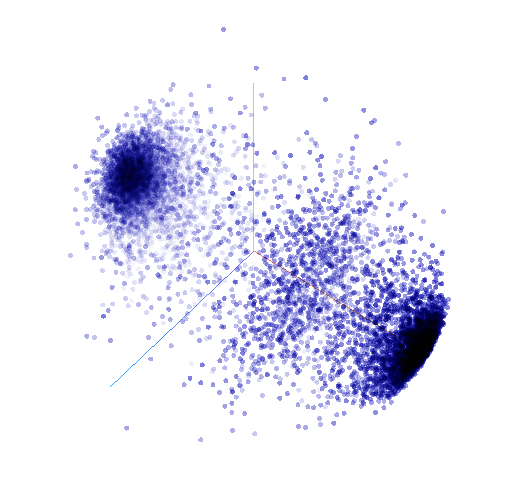

## Recurrent Neural Network (RNN)

RNN's are useful for sequence data

The premise of a RNN is to use the representation of a previous input to aid the representation of a later input

### Model 2: LSTM

LSTM = long short term memory (one of the most popular RNN cells)

Our structure of an RNN loks like

```
Input (text) -> Tokenize -> Embedding -> Layers (RNN/dense) -> Output (probability)
```

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64,return_sequences=True)(x) # when you are stacking RNN cells together, you need to set return_sequences = "True"
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64,activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2_LSTM")

In [ ]:
# Get a summary
model_2.summary()

In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])                

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])
                                                                                                                                         

In [ ]:
# Make predicitons with LSTM
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,y_pred=model_2_preds)
model_2_results, baseline_results

##  Model 3: GRU (Gated Recurrent Unit)

The GRU cell has similar features to LSTM cells but has less parameters

In [ ]:
# Create a GRU model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(units=64)(x) # need to set return_sequences = True if stacking RNN cells
# x = layers.LSTM(64,return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64,activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_GRU")

In [ ]:
# Get a model summary
model_3.summary()

In [ ]:
# Compile
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])            

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    "model_3_GRU")])

In [ ]:
# Make predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

In [ ]:
# Convert model 3 predprobs to labels
model_3_preds= tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

In [ ]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,y_pred=model_3_preds)
model_3_results, baseline_results

### Model 4: Bidirectional RNN

Normal RNN's go from (left to right), but with bidirectional RNN's we go from (right to left) then (left to right)

In [ ]:
# Build a bidirectional RNN
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs,outputs,name="model_4_bidirectional")

In [ ]:
# Get a model summary
model_4.summary()

In [ ]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])                

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

In [ ]:
# Make predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

In [ ]:
# Form predictions into labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

In [ ]:
# Calculate results and compare to baseline
model_4_results = calculate_results(y_true=val_labels,y_pred=model_4_preds)
model_4_results, baseline_results

##  Convolutional Neural Networks for Text (and other types of sequences)

We have used CNNs for images but images are typically 2D (height, width) ... however our text is 1D

Previously we've used Conv2D for our image data but now we are working with Conv1D

The typical structure of a Conv1D for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D and pooling) -> Outputs

```

### Model 5: Conv1D

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # looks at 5 words at a time
                        strides=1 # default
                        activation="relu",
                        padding="same") # "valid" means the dimension will be less, "same" means dimension will match input

conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to get the most important feature or get the feature with the highest value

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

In [ ]:
# Create a Conv1D model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation="relu",
                  padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs,outputs,name="model_5_Conv1D")

# Compile
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_5.summary()


In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_Conv1D")])

In [ ]:
# Make some predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

In [ ]:
# Calculate results and compare to baseline
model_5_results = calculate_results(y_true=val_labels,y_pred=model_5_preds)
model_5_results, baseline_results

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we have built a few of our own models, le's try and use transfer learning for NLP, specifically using [TensorFlow Hub's Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

In [2]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

NameError: name 'sample_sentence' is not defined

In [ ]:
# Let's evaluate the shape
embed_samples[0].shape

In [4]:
# Create a keras layer using the USE pretrained layer from tensorflow hub
import tensorflow as tf
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [29]:
from tensorflow.keras import layers

# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()                

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [30]:
from Functions.helper_functions import create_tensorboard_callback

SAVE_DIR = "model_log_nlp"

# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_log_nlp/tf_hub_sentence_encoder/20221230-080656
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.5072 - accuracy: 0.7847 - val_loss: 0.4494 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4141 - accuracy: 0.8168 - val_loss: 0.4386 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.4003 - accuracy: 0.8221 - val_loss: 0.4301 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3924 - accuracy: 0.8283 - val_loss: 0.4250 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3863 - accuracy: 0.8302 - val_loss: 0.4266 - val_accuracy: 0.8123


In [31]:
#  Make predictions
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs)) # convert predictions to labels
model_6_preds[:10]

24/24 [==============================] - 1s 13ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [32]:
# Calculate accuracy
from Functions.helper_functions import calculate_results

model_6_results = calculate_results(y_true=val_labels,y_pred=model_6_preds)
model_6_results, baseline_results

({'accuracy': 81.23359580052494,
  'precision': 0.8142769487815527,
  'recall': 0.8123359580052494,
  'f1': 0.8108895606331169},
 {'accuracy': 79.26509186351706,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1': 0.7862189758049549})

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you dont have a large dataset.

To see how our model performs on a smaller datset, let's replicate `model_6` except we'll train it on 10% of the data

In [48]:
# WARNING: Making data splits like below leads to data leakage

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1,random_state=42)
# train_10_percent.head(), len(train_10_percent)

# # Grab data from 10 percent variable
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [51]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences)) # len = 685

train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [53]:
# Check the number of targets in our subset of data
import numpy as np
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

To re-create a model the same as a previous model you've created you can use the `tf.keras.models.clone_model`

In [54]:
# Let's build a model the same as model 6
# model_7 = tf.keras.models.clone_model(model_6)

model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
], name="model_7_USE")


# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [55]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences,val_labels), # data LEAKAGE!
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_log_nlp/tf_hub_sentence_encoder_10_percent_correct_split/20221230-103604
Epoch 1/5
22/22 [==============================] - 2s 52ms/step - loss: 0.6649 - accuracy: 0.6920 - val_loss: 0.6474 - val_accuracy: 0.7060
Epoch 2/5
22/22 [==============================] - 1s 30ms/step - loss: 0.5949 - accuracy: 0.7869 - val_loss: 0.5909 - val_accuracy: 0.7520
Epoch 3/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5205 - accuracy: 0.8190 - val_loss: 0.5380 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4607 - accuracy: 0.8321 - val_loss: 0.5008 - val_accuracy: 0.7900
Epoch 5/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4192 - accuracy: 0.8380 - val_loss: 0.4902 - val_accuracy: 0.7913


In [56]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

24/24 [==============================] - 1s 15ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [57]:
# Calucalte results
model_7_results = calculate_results(y_true=val_labels,y_pred=model_7_preds)
model_7_results, model_6_results

({'accuracy': 79.13385826771653,
  'precision': 0.7939542015160368,
  'recall': 0.7913385826771654,
  'f1': 0.7892663801484977},
 {'accuracy': 81.23359580052494,
  'precision': 0.8142769487815527,
  'recall': 0.8123359580052494,
  'f1': 0.8108895606331169})